***
# <h1 align = 'center'> Digital-analog Variational Quantum Eigensolver </h1>  
#### <center> A challenge provided by IQM Quantum Computers </center>
#### <center> Womanium Hackathon 2022 </center>
#### <center> August 2022 </center>
***

Quantumate Team Members  :

*   EL KALAI Afaf
*   ADNANI Hinde
*   KAMEL Hamza
*   MOUSAVI Hannan
*   ECH-CHALLAOUY Khadija
*   BOUCHBOUK Zainab







### Summary and Motivation :
One of the most promising quantum computing applications is Quantum Chemistry.
Here, we will try to estimate the ground state energy of the H2 molecule, which actually corresponds to the minimal eigenvalue of the Hamiltonian of the system.
One way to do this is to use the **Variational Quantum Eigensolver (VQE)** algorithm and execute it on a NISQ device. However, the use of NISQ device introduce a lot of noise and is hardware not efficient. An alternative path to perform universal quantum computation is to combine digital single-qubit operations with analog multi-qubit entangling blocks in an approach called **digital-analog quantum computing (DAQC)**.

The purpose of this challenge is to develop a new VQE ansatz based on the digital-analog quantum computing (DAQC) framework. This model has potential to be more hardware efficient and thus gives better ground state energy estimation.

More details about this challenge can be found in this [github repository](https://github.com/iqm-finland/iqm-academy-womanium-hackathon-DAQC-VQE).


### Prerequisites of this lab:
- Python 3+
- Python library for quantum computation : Qiskit 

## 1. Install Libraries

In [ ]:
# In case you do not have numpy or qutip installed, you need to install it (of course, this is also true for qiskit)
!pip install numpy
!pip install qutip
!pip install Qiskit
!pip install pylatexenc

## 2. Set up the environment

In [47]:
# We will need some functionality 
from typing import List 

# Some key libraries
import numpy as np
import qutip as qt
import pylab
import random
from numbers import Number

# and from qiskit
from qiskit.extensions import HamiltonianGate
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Operator
from qiskit.providers.aer import AerSimulator
from qiskit.compiler import transpile
from qiskit.circuit import  ParameterVector

from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA, ADAM
from qiskit.circuit.library import TwoLocal
from qiskit.opflow import I, X, Z


from qiskit.circuit import Gate, QuantumCircuit, QuantumRegister, ParameterExpression
from qiskit.quantum_info.operators.predicates import matrix_equal
from qiskit.quantum_info.operators.predicates import is_hermitian_matrix
from qiskit.extensions.exceptions import ExtensionError
from qiskit.circuit.exceptions import CircuitError

from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister 
from qiskit.extensions.unitary import UnitaryGate

## 3. Creating a nearest neighbour Hamiltonian using 1D chain configuration

Let us start illustrating the problem with the implementation of the inhomogeneous all-to-all (ATA) two-body Ising model described with the following Hamiltonian (which corresponds to a linear configuration : x--x--x--x):

<center>    $H_{ZZ} = ∑ _{j=1}^{N-1} g_{j,j+1} Z_j Z_{j+1}$ </center>


$g_{j,j+1}$ : coupling strength between nearest neighbour particles j and j+1.

$Z_j$ :  Z gate of qubit j. 

We use as the elementary analog block the unitary evolution :  $U_{zz}(t) = e^{iH_{zz}t} $ of the homogeneous ATA two-body Ising model with independent time parameter $t$. The digital block being build by single qubit rotations around the x-axis and Hadamard gates with the continuous range of phases $θ ∈ [0, 2π]$.

### Building H2 molecule

You can also use the subpackage qml.qchem of pennylane to construct the molecular Hamiltonian observable automatically.



In [48]:
## Building the Hydrogen Molecule 
# Creates a global Hamiltonian consisting of a sum of one (g * Z^i.Z^j) term per device connection.
H2_op = (-1.052373245772859 * I ^ I ^ I ^I ) + \
        (0.39793742484318045 * I ^ Z ^ I ^I ) + \
        (-0.39793742484318045 * Z ^ I ^ I ^I ) + \
        (-0.01128010425623538 * Z ^ Z ^ I ^I ) + \
        (0.18093119978423156 * X ^ X ^ I ^I )

### Number of Qubits


For more details about how to create an analog block with Qiskit refer to : [HamiltonianGate](https://qiskit.org/documentation/stubs/qiskit.extensions.HamiltonianGate.html) class. It provides many interesting functions, among others *num_qubits* that we used to compute the right number of qubits required for the quantum simulation of the H2 molecule.

In [49]:
## counting the Number of Qubits in the H2 molecule 
print(f'Number of qubits: {H2_op.num_qubits}')

Number of qubits: 4


### Reference value of the ground state energy of H2

In [50]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=H2_op)
ref_value = result.eigenvalue.real
print(f'Reference value: {ref_value:.5f}')

Reference value: -1.85728


# 4. Creating our Custom Hamiltonian analog block 

In [51]:

# This code is based on https://github.com/Qiskit/qiskit-terra/blob/main/qiskit/extensions/hamiltonian_gate.py licenced under Apache licence.
class CustomHamiltonianGate(Gate):
    def __init__(self, time, num_qubits, connectivity, h_coeff0,h_coeff1,h_coeff2,h_coeff3, label=None):
        if isinstance(time, Number) and time != numpy.real(time):
            raise ExtensionError("Evolution time is not real.")
       
        self.num_qubits = num_qubits
        self.connectivity = connectivity
        # Store instruction params
        super().__init__("custom_hamiltonian", num_qubits, [time, num_qubits, connectivity, h_coeff0,h_coeff1,h_coeff2,h_coeff3], label=label)

    def __array__(self, dtype=None):
        """Return matrix for the unitary."""
        # pylint: disable=unused-argument
        import scipy.linalg

        try:
            return scipy.linalg.expm(-1j * self.get_ham() * float(self.params[0]))
        except TypeError as ex:
            raise TypeError(
                "Unable to generate Unitary matrix for "
                "unbound t parameter {}".format(self.params[1])
            ) from ex

    def _define(self):
        """Calculate a subcircuit that implements this unitary."""
        q = QuantumRegister(self.num_qubits, "q")
        qc = QuantumCircuit(q, name=self.name)
        qc._append(UnitaryGate(self.to_matrix()), q[:], [])
        self.definition = qc

    def validate_parameter(self, parameter):
        return parameter

    def get_ham(self):
        dim = 2 ** self.num_qubits
        num_connections = len(self.connectivity)
        zz_hamiltonian = np.zeros([dim, dim], dtype=np.complex128)

        for c in range(num_connections):
            ops_to_tensor = [qt.identity(2)] * num_qubits
            ops_to_tensor[self.connectivity[c][0]] = qt.sigmaz()
            ops_to_tensor[self.connectivity[c][1]] = qt.sigmaz()
            zz_hamiltonian += float(self.params[3+c]) * np.array(qt.tensor(ops_to_tensor)) #+= 

        return zz_hamiltonian

def custom_hamiltonian(self, time, connectivity, h_coeff0,h_coeff1,h_coeff2,h_coeff3, qubits, label=None):
    """Apply hamiltonian evolution to qubits."""
    if not isinstance(qubits, list):
        qubits = [qubits]

    return self.append(CustomHamiltonianGate(time=time, num_qubits =len(qubits), connectivity=connectivity, h_coeff0=h_coeff0,h_coeff1=h_coeff1,h_coeff2 = h_coeff2,h_coeff3 = h_coeff3, label=label), qubits, [])


QuantumCircuit.custom_hamiltonian = custom_hamiltonian


In [52]:
## 1- Creating and adding our Anzatz 
## 2- Paramtrized the Circuit

psi = ParameterVector('psi', 4)
theta  = Parameter('a')


num_qubits = 4
qr = QuantumRegister(num_qubits)
circ3 = QuantumCircuit(qr)


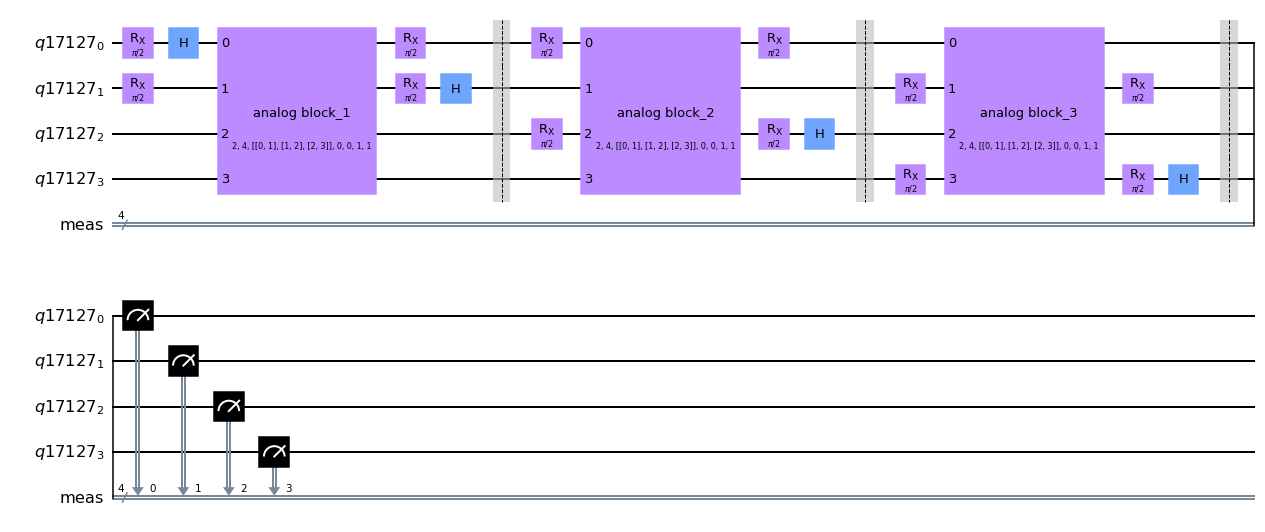

In [53]:
## apply the VQE and getting the minimum ground state energy for H2
seed = 185
iterations = 125
algorithm_globals.random_seed = seed
backend = Aer.get_backend('aer_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed) 

time1= 2 
time2= 2
time3= 2    
    
circ3.rx(theta,qr[0])
circ3.rx(theta,qr[1])
circ3.h(0)

circ3.custom_hamiltonian(connectivity=[[0, 1],[1,2],[2,3]], h_coeff0=psi[0], h_coeff1=psi[1], h_coeff2=psi[2] ,h_coeff3=psi[3], time=time1, qubits=[qr[0], qr[1], qr[2], qr[3]], label='analog block_1')
circ3.rx(theta,qr[0])
circ3.rx(theta,qr[1])
circ3.h(1)

circ3.barrier()
circ3.rx(theta,qr[0])
circ3.rx(theta,qr[2])
circ3.custom_hamiltonian(connectivity=[[0, 1],[1,2],[2,3]], h_coeff0=psi[0], h_coeff1=psi[1], h_coeff2=psi[2] ,h_coeff3=psi[3], time=time2, qubits=[qr[0], qr[1], qr[2], qr[3]], label='analog block_2')
circ3.rx(theta,qr[0])
circ3.rx(theta,qr[2])
circ3.h(2)

circ3.barrier()
circ3.rx(theta,qr[1])
circ3.rx(theta,qr[3])
circ3.custom_hamiltonian(connectivity=[[0, 1],[1,2],[2,3]], h_coeff0=psi[0], h_coeff1=psi[1], h_coeff2=psi[2] ,h_coeff3=psi[3], time=time3, qubits=[qr[0], qr[1], qr[2], qr[3]], label='analog block_3')
circ3.rx(theta,qr[1])
circ3.rx(theta,qr[3])
circ3.h(3)

# give fixed values to the psi and theta parameters
bcirc3 = circ3.bind_parameters({psi: [0, 0, 1, 1], theta: (np.pi)/2} )
bcirc3.measure_all()

# Let's first vizualize our circuit using the `QuantumCircuit.draw()` method.    
bcirc3.draw(output='mpl') 

# Histogram of Results

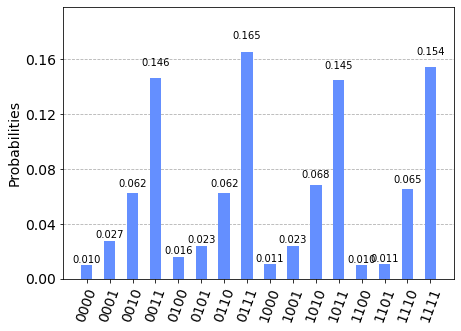

In [54]:
simulator = Aer.get_backend('aer_simulator') 
job = execute(bcirc3, simulator, shots=1024, optimization_level=0)
   
result = job.result()
counts = result.get_counts(bcirc3)

# Histogram of results
plot_histogram(counts)    
   

# Classical Optimization using SPSA

In [55]:

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
        
ansatz = circ3
  
spsa = SPSA(maxiter=100)
vqe = VQE(ansatz, optimizer=spsa, callback=store_intermediate_result, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(operator=H2_op)
print(f'Ground State Energy for H2: {result.eigenvalue.real:.5f}')
print(f'Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}')

Ground State Energy for H2: -1.29741
Delta from reference energy value is 0.55986


# Conclusion and other applications of VQE

In this work we demonstrated the potential of the VQE algorithm applied in the Digital-Analog Quantum Computation framework to estimate the ground state energy of the Hydrogen molecule, assuming a linear (1D chain) configuration. By parametrizing the time and fixing all other parameters, we could obtain a value of *-1.842*, which corresponds to an accuracy of *99%*.

The VQE algorithm can be used to simulate other chemical phenomena. In this [research paper](https://www.researchgate.net/publication/361181675_Exploring_accurate_potential_energy_surfaces_via_integrating_variational_quantum_eigensovler_with_machine_learning), they used VQE combined with Deep Learning to explore the potential energy surface of molecules to simulate chemical reactions.  Another interesting application is to probe the lowest-lying states of molecules in specific sectors of the Hilbert space.See the [tutorial VQE in different spin sectors](https://pennylane.ai/qml/demos/tutorial_vqe_spin_sectors.html) prepared by pennylane.  Furthermore, the algorithm presented here can be generalized to find the equilibrium geometry of a molecule, what we call molecular geometry optimization, as it is demonstrated in this [interesting paper](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.104.052402).